<a href="https://colab.research.google.com/github/alimoorreza/CS167-notes/blob/main/Day22_Convolutional_Neural_Network_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS167: Day22
## Deep Learning and Convolutional Neural Network (CNN)

#### CS167: Machine Learning, Fall 2023

Tuesday, 21th, 2023


📆 [Course Schedule](https://analytics.drake.edu/~reza/teaching/cs167_fall23/cs167_schedule.html) | 📜 [Syllabus](https://analytics.drake.edu/~reza/teaching/cs167_fall23/cs167_syllabus_fall23.pdf)


In [ ]:
# import torch library
import torch
import torch.nn as nn
import numpy as np

## __Put the Model on Training Device (GPU or CPU)__
We want to accelerate the training process using graphical processing unit (GPU). Fortunately, in Colab we can access for GPU. You need to enable it from _Runtime-->Change runtime type-->GPU or TPU_

In [ ]:
# check to see if torch.cuda is available, otherwise it will use CPU
import torch
import torch.nn as nn
import numpy as np
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cpu device


#__Load the Dataset for your CNN__

We can easily import some [built-in datasets](https://pytorch.org/vision/stable/datasets.html) from PyTorch's [torchvision.datasets](torchvision.datasets) module
- [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist)
  - each image size: 28x28 grayscale image
  - each image is associated with a label from __10 classes__
  - training set of 60,000 examples and a test set of 10,000 examples

<div>
<img src="https://analytics.drake.edu/~reza/teaching/cs167_fall23/notes/images/fashion-mnist-sprite.png" width=500/>
</div>


In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets # torchvision has many deep learning benchmark datasets Fashion-MNIST, CIFAR-10, Caltech-50, etc
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root="/content/drive/MyDrive/cs167_fall23/datasets",
    train=True,
    download=True,
    transform=ToTensor() # specify the feature and label transformations
)

test_data = datasets.FashionMNIST(
    root="/content/drive/MyDrive/cs167_fall23/datasets",
    train=False,
    download=True,
    transform=ToTensor()
)

__Explore some sample training images__

In [ ]:
# Visualize a random set of images and their the labels from the training split
# The following labels represent 10 classes, each with specific indices as defined by the creator of the Fashion-MNIST dataset
# reference: https://github.com/zalandoresearch/fashion-mnist#labels
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(5, 5))
cols, rows = 5, 2
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    #print('image tensor size:', img.shape)
    plt.imshow(img.squeeze(), cmap="gray") # .squeeze() method removes the '1' from first dimension of the tensor [1, 28, 28]
    #print('after removing the first dimension with ', img.squeeze().shape)
plt.show()

##__Prepare Your Data with DataLoader for Training/Testing__
We just explored one sample of data at a time. As we have seen in our discussion of the optimizer, specifically __Stochastic Gradient Descent (SGD)__, during training your network, we may need to pass them in __minibatches__. PyTorch has a module called __DataLoader__, which will do this automatically for us as long as we provide the right arguments:
- prepare the __minibatches__ with the given _batch_size_ eg 16, 32, 64, 128, etc
- multiprocessing to speed up the data retrieval
- reshuffle the data at every __epoch__


In [ ]:
from torch.utils.data import DataLoader
#                              pairs of items,   minibatch size,      random shuffling turned ON
train_dataloader = DataLoader(training_data,     batch_size=128,        shuffle=True)
test_dataloader  = DataLoader(test_data,         batch_size=128,        shuffle=False) # for testing/inference: it is not necessary to shuffle

# explore the data from the train_dataloader
train_inputs, train_labels = next(iter(train_dataloader)) # returns a batch of 128 train-images and train-labels
print(f"Images batch shape: {train_inputs.shape}")
print(f"Labels batch shape: {train_labels.shape}")

# visualize one of the samples in this batch of 128
figure = plt.figure(figsize=(2, 2))
img = train_inputs[127].squeeze() # I picked 127 but you can pick any index in between 0 to batch_size=128
label = train_labels[127]         # It's a tensor datatype
plt.title(labels_map[int(label)]) # For indexing, convert the 'tensor' datatype --> integer number datatype
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

#__Building Convolutional Neural Network (CNN)__

Create a network class with two methods:
- _init()_
- _forward()_


In [ ]:
import torch
from torch import nn

# You can give any name to your new network, e.g., SimpleCNN.
# However, you have to mandatorily inherit from nn.Module to
# create your own network class. That way, you can access a lot of
# useful methods and attributes from the parent class nn.Module

class SimpleCNN(nn.Module):
  def __init__(self):
    super().__init__()
    # your network layer construction should take place here
    # ...
    # ...

  def forward(self, x):
    # your code for MLP forward pass should take place here
    # ...
    # ...
    return x

Let's create the CNN as shown in the picture above using this template. In general, we will follow this template for constructing other neural networks such as MLP, CNN, RNN, and Transformer in PyTorch. Hence, it is a very generic setup. Here are the useful PyTorch modules we will be using for CNN construction:
- [nn.Conv2d()](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)
  - applies a 2D convolution over an input volume of $(C_{in}​,H_{in},W_{in})$ and produces an output volume of $(C_{out}​,H_{out},W_{out})$   between two adjacent layers.
  - to create this, you need to provide the followings:
    - __channel_dimension_of_input_layer__ i.e., $C_{in}$
    - __channel_dimension_of_output_layer__ i.e., $C_{out}$
    - __filter_size__ i.e., $F$

  - the other two optional parameters are __stride__: $S=1$ and __padding__: $P=0$, with default values as shown. As discussed in class, PyTorch will calculate internally the sizes of output volume $H_{out}$ and $W_{out}$ from the above mentioned parameter values

<div>
<img src="https://analytics.drake.edu/~reza/teaching/cs167_fall23/notes/images/convolution-animation-3x3-kernel" width=800/>
</div>

[Source of this excellent visualization that vividly illustrates the proces](https://animatedai.github.io/)


In [59]:
import torch
from torch import nn
import pdb

class SimpleCNNv1(nn.Module):
  def __init__(self):
    super().__init__()
    # your network layer construction should take place here

    input_volume_channel_first      = 1
    output_volume_channel_first     = 32
    input_volume_channel_second     = 32
    output_volume_channel_second    = 64
    num_of_neurons_output_layer     = 10 # usually this number should be equal to the total number of classes in your classification task

    # Beginning layers: a series of 2D convolutional layers (useful for feature map learning from the grid layouts of an image)
    self.first_conv_2d              = nn.Conv2d(input_volume_channel_first, output_volume_channel_first, 3)  # 2D convolutional transformation module :input_volume_channel=1, output_volume_channel=32, filter_size= (3x3)
    self.relu_activation_1st        = nn.ReLU()
    self.second_conv_2d             = nn.Conv2d(input_volume_channel_second, output_volume_channel_second, 3) # 2D convolutional transformation module :input_volume_channel=32, output_volume_channel=64, filter_size= (3x3)
    self.relu_activation_2nd        = nn.ReLU()

    # --------------------------------------------------------------------------
    # -------                 heads up!                                 --------
    # you need to calculate the total_size_of_the_output_volume of your self.second_conv_2d layer,
    # as it will be needed by the upcoming nn.Linear(). This number will be used as the first argument for the next nn.Linear().
    # I pre-calculated this number, and it is 64*24*24 = 36864. I will plug this number in the next layer
    # --------------------------------------------------------------------------

    # End layers: a series of dense linear layers (almost like an MLP for final classification)
    self.first_linear_layer         = nn.Linear(64*24*24, 128)  # linear transformation module (input=64*24*24, output=128)
    self.relu_activation_3rd        = nn.ReLU()
    self.output_layer               = nn.Linear(128, num_of_neurons_output_layer) # linear transformation module (input=128, output=10)


  def forward(self, x):
    # your code for Conv_2d forward pass should take place here
    output = self.first_conv_2d(x)
    output = self.relu_activation_1st(output)
    print('first_conv_2d output feature map size: ', output.shape)
    output = self.second_conv_2d(output)
    output = self.relu_activation_2nd(output)
    print('second_conv_2d output feature map size: ', output.shape)

    output = torch.flatten(output, 0)

    # your code for MLP forward pass should take place here
    output = self.first_linear_layer(output)
    print('first linear layer feature map shape: ', output.shape)
    output = self.relu_activation_3rd(output)
    output = self.output_layer(output)
    print('Output linear layer feature map shape: ', output.shape)


    return output


In [60]:
# check the structure of your MLP
cnn_model = SimpleCNNv1()
print(cnn_model)

SimpleCNNv1(
  (first_conv_2d): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu_activation_1st): ReLU()
  (second_conv_2d): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (relu_activation_2nd): ReLU()
  (first_linear_layer): Linear(in_features=36864, out_features=128, bias=True)
  (relu_activation_3rd): ReLU()
  (output_layer): Linear(in_features=128, out_features=10, bias=True)
)


In [54]:
# check the sizes of weights and biases of your MLP's 1st hidden layers
print('size of weights of first_hidden_layer: \n ', cnn_model.first_conv_2d.weight.shape)
print('size of bias of first_hidden_layer: \n ', cnn_model.first_conv_2d.bias.shape)

size of weights of first_hidden_layer: 
  torch.Size([32, 1, 3, 3])
size of bias of first_hidden_layer: 
  torch.Size([32])


In [ ]:
# check the randomly initialized values of weights and biases of your MLP's 1st hidden layers
print('weights of first_conv_2d.weight: \n ', cnn_model.first_conv_2d.weight)
print('bias of first_conv_2d.weight: \n ', cnn_model.first_conv_2d.bias)

#__Forward Pass using your Dataset and your CNN__
Test a forward pass of our first CNN using one of the training samples.
The forward method inside our network class, __SimpleCNNv1__, will be invoked if we provide an input tensor __X__ to the network object we instantiated earlier, i.e., __cnn_model__, as follows:
- _output = cnn_model(X)_

Finally, we convert the ouput from the model into probabilities using __Softmax()__ module:
- _pred_probab = softmax_activation(output)_



In [61]:
img   = train_inputs[100] # I picked 100 but you can pick any index in between 0 to batch_size=128
label = train_labels[100]

softmax_activation = nn.Softmax(dim=0)

print('shape of X: ', img.shape)
output      = cnn_model(img)                # last layer of our network will return 10 values each will range in between in [-infty, infty]
pred_probab = softmax_activation(output)   # these raw numbers scaled to values [0, 1] representing the model’s predicted probabilities for each class
print('predited probability \n', pred_probab)
y_pred      = pred_probab.argmax()
print(f"Predicted class: {y_pred}")


shape of X:  torch.Size([1, 28, 28])
first_conv_2d output feature map size:  torch.Size([32, 26, 26])
second_conv_2d output feature map size:  torch.Size([64, 24, 24])
first linear layer feature map shape:  torch.Size([128])
Output linear layer feature map shape:  torch.Size([10])
predited probability 
 tensor([0.1045, 0.0968, 0.1049, 0.1040, 0.1037, 0.0956, 0.0984, 0.1012, 0.0988,
        0.0920], grad_fn=<SoftmaxBackward0>)
Predicted class: 2


In [62]:
# model parameter counts to find out how many parameter this model will learn from the data
for name, param in cnn_model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} \n")


Layer: first_conv_2d.weight | Size: torch.Size([32, 1, 3, 3]) 

Layer: first_conv_2d.bias | Size: torch.Size([32]) 

Layer: second_conv_2d.weight | Size: torch.Size([64, 32, 3, 3]) 

Layer: second_conv_2d.bias | Size: torch.Size([64]) 

Layer: first_linear_layer.weight | Size: torch.Size([128, 36864]) 

Layer: first_linear_layer.bias | Size: torch.Size([128]) 

Layer: output_layer.weight | Size: torch.Size([10, 128]) 

Layer: output_layer.bias | Size: torch.Size([10]) 



##__Defining Loss function__

- [nn.CrossEntropyLoss()](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss)
  - useful when training a __classification problem__ with __C__ classes.
  - criterion computes the cross entropy loss between input logits and target
- [nn.MSELoss()](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss)
  - useful when training a __regression problem__
  - criterion that measures the mean squared error (squared L2 norm) between each element in the input _x_ and target _y_


In [63]:
# initialize the loss function
loss_fn = nn.CrossEntropyLoss() # this is useful for multiclass classification task

##__Initializing the Optimizer__

Optimiztaion, as we have discussed in previous week, is process of adjusting model parameters to reduce model error in each training step. PyTorch provides a selection of optimization algorithms in the [torch.optim](https://pytorch.org/docs/stable/optim.html) package. Some of them are as follows:
- [torch.optim.SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD)
- [torch.optim..Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)
- [torch.optim.RMSprop](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html#torch.optim.RMSprop)

In addition to selecting the optimizer, we can also select the yperparameters which are refered to as adjustable parameters crucial for controlling the model optimization process. You can influence the training and convergence of the model by tweaking these hyperparameters:
- __epochs:__ denotes the number of iterations over the dataset
- __batch size:__ represents the quantity of data samples in each iteration propagated through the network before updating the parameters
- __learning rate:__ determines the extent of parameter updates made at each batch/epoch



In [66]:
learning_rate = 1e-3
batch_size    = 64
epochs        = 10
# let's use SGD optimization algorithm for training our model
optimizer     = torch.optim.SGD(cnn_model.parameters(), lr=learning_rate)

__Simpliefy the CNN Network with PyTorch's Sequential() Module__

In [1]:
import torch
from torch import nn
import pdb

class SimpleCNNv2(nn.Module):
  def __init__(self):
    super().__init__()
    # your network layer construction should take place here

    input_volume_channel_first      = 1
    output_volume_channel_first     = 32
    input_volume_channel_second     = 32
    output_volume_channel_second    = 64
    num_of_neurons_output_layer     = 10 # usually this number should be equal to the total number of classes in your classification task

    # Beginning layers: a series of 2D convolutional layers (useful for feature map learning from the grid layouts of an image)
    self.conv_layers = nn.Sequential(
            nn.Conv2d(input_volume_channel_first, output_volume_channel_first, 3),  # 2D convolutional transformation module :input_volume_channel=3, output_volume_channel=32, filter_size= (3x3)
            nn.ReLU(),
            nn.Conv2d(input_volume_channel_second, output_volume_channel_second, 3), # 2D convolutional transformation module :input_volume_channel=32, output_volume_channel=64, filter_size= (3x3)
            nn.ReLU()
        )

    # --------------------------------------------------------------------------
    # -------                 heads up!                                 --------
    # you need to calculate the total_size_of_the_output_volume of your self.second_conv_2d layer,
    # as it will be needed by the upcoming nn.Linear(). This number will be used as the first argument for the next nn.Linear().
    # I pre-calculated this number, and it is 64*24*24 = 36864. I will plug this number in the next layer
    # --------------------------------------------------------------------------
    self.flatten                    = nn.Flatten()

    # End layers: a series of dense linear layers (almost like an MLP for final classification)
    self.linear_layers = nn.Sequential(
            nn.Linear(64*24*24, 128),  # linear transformation module (input=64*24*24, output=128)
            nn.ReLU(),
            nn.Linear(128, num_of_neurons_output_layer) # linear transformation module (input=128, output=10)
        )


  def forward(self, x):
    # your code for Conv_2d forward pass should take place here
    output = self.conv_layers(x)
    output = self.flatten(output)
    output = self.linear_layers(output)
    return output

cnn_model = SimpleCNNv2()
print(cnn_model)

SimpleCNNv2(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_layers): Sequential(
    (0): Linear(in_features=36864, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)


#__Putting Everything Together CNN__

__Putting Everything Together using our SimpleCNNv2 Network on Fashion-MNIST Dataset__


SimpleCNNv2(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_layers): Sequential(
    (0): Linear(in_features=36864, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)
Epoch 1
-------------------------------
loss: 2.302379  [   64/60000]
loss: 2.199876  [ 6464/60000]
loss: 1.983157  [12864/60000]
loss: 1.742227  [19264/60000]
loss: 1.346542  [25664/60000]
loss: 1.095899  [32064/60000]
loss: 1.022684  [38464/60000]
loss: 0.839562  [44864/60000]
loss: 0.867055  [51264/60000]
loss: 0.856059  [57664/60000]
Test Error: 
 Accuracy: 73.4%, Avg loss: 0.779309 

Epoch 2
-------------------------------
loss: 0.750698  [   64/60000]
loss: 0.807368  [ 6464/60000]
loss: 0.539248  [12864/60000]
loss: 0.822183  [19264/60000]
loss: 0.721650  [25664/60000]

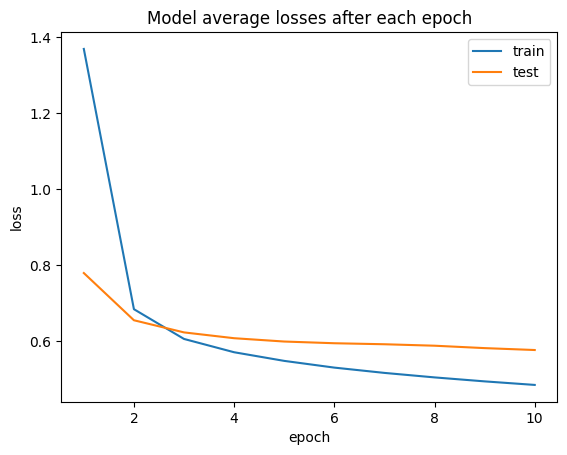

In [4]:
# Step 1: load the Torch library and other utilities
#----------------------------------------------------

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

# Step 2: load the dataset, ie, we are experimenting with Fashion-MNIST
#--------------------------------------------------------------------------------------------------

training_data = datasets.FashionMNIST(
    root="fashion_mnist",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="fashion_mnist",
    train=False,
    download=True,
    transform=ToTensor()
)

# Step 3: Create your CNN Network (call it SimpleCNNv2) with 2 conv_2d layers + 2 layers of MLP
#--------------------------------------------------------------------------------------------------
class SimpleCNNv2(nn.Module):
  def __init__(self):
    super().__init__()
    # your network layer construction should take place here

    input_volume_channel_first      = 1
    output_volume_channel_first     = 32
    input_volume_channel_second     = 32
    output_volume_channel_second    = 64
    num_of_neurons_output_layer     = 10 # usually this number should be equal to the total number of classes in your classification task

    # Beginning layers: a series of 2D convolutional layers (useful for feature map learning from the grid layouts of an image)
    self.conv_layers = nn.Sequential(
            nn.Conv2d(input_volume_channel_first, output_volume_channel_first, 3),  # 2D convolutional transformation module :input_volume_channel=3, output_volume_channel=32, filter_size= (3x3)
            nn.ReLU(),
            nn.Conv2d(input_volume_channel_second, output_volume_channel_second, 3), # 2D convolutional transformation module :input_volume_channel=32, output_volume_channel=64, filter_size= (3x3)
            nn.ReLU()
        )
    # --------------------------------------------------------------------------
    # -------                 heads up!                                 --------
    # you need to calculate the total_size_of_the_output_volume of your self.second_conv_2d layer,
    # as it will be needed by the upcoming nn.Linear(). This number will be used as the first argument for the next nn.Linear().
    # I pre-calculated this number, and it is 64*24*24 = 36864. I will plug this number in the next layer
    # --------------------------------------------------------------------------

    self.flatten                    = nn.Flatten()

    # End layers: a series of dense linear layers (almost like an MLP for final classification)
    self.linear_layers = nn.Sequential(
            nn.Linear(64*24*24, 128),  # linear transformation module (input=64*24*24, output=128)
            nn.ReLU(),
            nn.Linear(128, num_of_neurons_output_layer) # linear transformation module (input=128, output=10)
        )


  def forward(self, x):
    # your code for Conv_2d forward pass should take place here
    output = self.conv_layers(x)
    output = self.flatten(output)
    output = self.linear_layers(output)

    return output

cnn_model = SimpleCNNv2()
print(cnn_model)

# Step 4: Your training and testing functions (you can copy it from the previous demo)
#--------------------------------------------------------------------------------------


def train_loop(dataloader, model, loss_fn, optimizer):

    size = len(dataloader.dataset)

    model.train()                   # set the model to training mode for best practices

    train_loss = 0
    correct    = 0

    for batch, (X, y) in enumerate(dataloader):
        # compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

            # compute the accuracy
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    return train_loss/len(dataloader), 100*correct

def test_loop(dataloader, model, loss_fn):

    model.eval()                    # set the model to evaluation mode for best practices

    size        = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, 100*correct

# Step 5: prepare the DataLoader and select your optimizer and set the hyper-parameters for learning the model from DataLoader
#------------------------------------------------------------------------------------------------------------------------------

learning_rate = 1e-3
batch_size_val = 64
epochs = 10
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cnn_model.parameters(), lr=learning_rate)

train_dataloader = DataLoader(training_data, batch_size=batch_size_val)
test_dataloader = DataLoader(test_data, batch_size=batch_size_val)


train_losses = []
test_losses  = []
train_accuracies = []
test_accuracies = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    avg_train_loss, train_accuracy = train_loop(train_dataloader, cnn_model, loss_fn, optimizer)
    avg_test_loss, test_accuracy  = test_loop(test_dataloader, cnn_model, loss_fn)
    # save the losses and accuracies
    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
print("SimpleCNNv2 model has been trained!")

# visualizing the loss curves
plt.plot(range(1,epochs+1), train_losses)
plt.plot(range(1,epochs+1), test_losses)
plt.title('Model average losses after each epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()


In [ ]:
# visualizing the accuracy curves
plt.plot(range(1,epochs+1), '-', label=train_accuracies)
plt.plot(range(1,epochs+1), '*', label=test_accuracies)
plt.title('Model accuracies after each epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.legend(loc='lower right')
plt.show()


#__Group Exercise__:
Create another CNN with 3 layers of 2D convolution and then train that model on the Fashion-MNIST dataset using the SGD optimizer with a batch size of 64. If time permits, you can also train another CNN with the ADAM optimizer and observe if there is any change in training.

In [ ]:
# Step 1: load the Torch library and other utilities
#----------------------------------------------------


In [ ]:
# Step 2: load the dataset, ie, we are experimenting with Fashion-MNIST
#--------------------------------------------------------------------------------------------------


In [ ]:
# Step 3: Create your CNN Network (call it SimpleCNNv3) with 3 conv_2d layers
#--------------------------------------------------------------------------------------------------


In [ ]:
# Step 4: Your training and testing functions (I copied it previous the previous demo. You don't need to change anything)
#--------------------------------------------------------------------------------------

def train_loop(dataloader, model, loss_fn, optimizer):

    size = len(dataloader.dataset)

    model.train()                   # set the model to training mode for best practices

    train_loss = 0

    for batch, (X, y) in enumerate(dataloader):
        # compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    return train_loss/len(dataloader)

def test_loop(dataloader, model, loss_fn):

    model.eval()                    # set the model to evaluation mode for best practices

    size        = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss


In [ ]:
# Step 5: prepare the DataLoader and select your optimizer and set the hyper-parameters for learning the model from DataLoader
#------------------------------------------------------------------------------------------------------------------------------
# Initialize your hyper-parameter and optimizer with appropriate values
# Use your dataset to prepare your DataLoaders one for training_data and one for test_data
# ...
# ...

print("SimpleCNNv3 model has been trained!")


In [ ]:
# visualizing the loss curves
